In [83]:
import os
from urllib import request

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [10]:
data_dirname = "data"

data_meta = [
    {
        "url": "https://d37ci6vzurychx.cloudfront.net/trip-data/fhv_tripdata_2021-01.parquet",
        "local_path": os.path.join(data_dirname, "fhv_tripdata_2021-01.parquet"),
    },
    {
        "url": "https://d37ci6vzurychx.cloudfront.net/trip-data/fhv_tripdata_2021-02.parquet",
        "local_path": os.path.join(data_dirname, "fhv_tripdata_2021-02.parquet"),
    },
]

In [11]:
if not os.path.exists(data_dirname):
    os.mkdir(data_dirname)
    
for dm in data_meta:
    if not os.path.exists(dm['local_path']):
        request.urlretrieve(rd['url'], local_path)

In [12]:
jan = pd.read_parquet(data_meta[0]['local_path'])

In [13]:
# Q1. Downloading the data
# Read the data for January. How many records are there?
jan.shape[0]

1154112

In [14]:
# Q2. Computing duration
# What's the average trip duration in January?
jan['duration'] = (jan.dropOff_datetime - jan.pickup_datetime).dt.total_seconds() / 60
jan['duration'].mean()

19.1672240937939

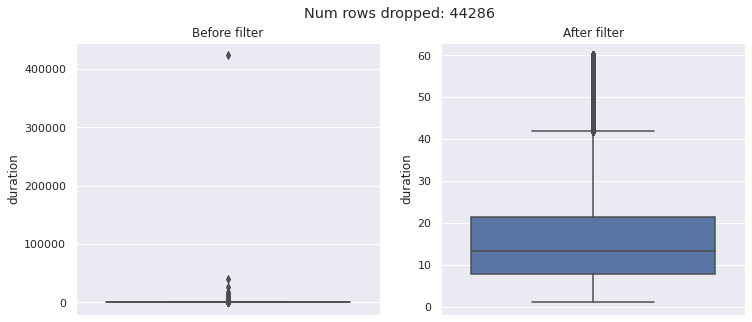

In [15]:
# Data preparation
# Check the distribution of the duration variable. There are some outliers.
# Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
# How many records did you drop?

duration_filter = (jan['duration'] >= 1) & (jan['duration'] <= 60)
jan_filt = jan.loc[duration_filter].copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Num rows dropped: {jan.shape[0] - jan_filt.shape[0]}")

sns.boxplot(y='duration', data=jan, ax=axes[0]).set(title="Before filter")
sns.boxplot(y='duration', data=jan_filt, ax=axes[1]).set(title="After filter");

In [67]:
# Q3. Missing values
# What's the fractions of missing values for the pickup location ID?
# I.e. fraction of "-1"s after you filled the NAs.
jan_filt['PUlocationID'] = jan_filt['PUlocationID'].fillna(-1).astype(np.int32)
jan_filt['DOlocationID'] = jan_filt['DOlocationID'].fillna(-1).astype(np.int32)

print(f"% of -1s of pickup location IDs: {(jan_filt['PUlocationID'] == -1).mean() * 100 :.1f}%")

% of -1s of pickup location IDs: 83.5%


In [86]:
# Q4. One-hot encoding
# Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
# What's the dimensionality of this matrix? (The number of columns).
features = ['PUlocationID', 'DOlocationID']

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(jan_filt[features])

X_train = enc.transform(jan_filt[features])

print(f"Dimensionality of matrix: {X_train.shape[1]}")

Dimensionality of matrix: 525


In [87]:
# Q5. Training a model
# Now let's use the feature matrix from the previous step to train a model.
#     Train a plain linear regression model with default parameters
#     Calculate the RMSE of the model on the training data
# What's the RMSE on train?
y_train = jan_filt['duration'].values

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

10.528519107205033

In [102]:
# Q6. Evaluating the model
# Now let's apply this model to the validation dataset (Feb 2021).
# What's the RMSE on validation?
feb = pd.read_parquet(data_meta[1]['local_path'])
feb['duration'] = (feb.dropOff_datetime - feb.pickup_datetime).dt.total_seconds() / 60

duration_filter = (feb['duration'] >= 1) & (feb['duration'] <= 60)
feb = feb[duration_filter]

X_val = enc.transform(feb[features].fillna(-1).astype(np.int32))
y_val = feb['duration'].values

y_pred = reg.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.014283136917232